In [1]:
import random
import json, pickle
import re
import os

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)

WORK_DIR = Path.cwd().parent


In [2]:
import sys
sys.path.append(str(WORK_DIR))
from src.datasets import STARDataset
from src import prompt_formatters
from src.STAR_utils.visualization_tools import visualization_tools as qaviz


In [3]:
RAW_VIDEO_DIR = Path(WORK_DIR / 'data/datasets/action-genome/Charades_v1_480/')
RAW_FRAME_DIR = Path(WORK_DIR / 'data/datasets/action-genome/frames/')
ANNOTATION_DIR = Path(WORK_DIR / 'src/STAR_utils/annotations/STAR_classes/')
FPS = pickle.load(open(ANNOTATION_DIR / 'video_fps','rb'))

SAVE_VIDEO_DIR = Path(WORK_DIR / "experiments/video_dump")


# Experiment - Gemma3 4b it-qat

Analysis on the performance of Gemma3 4b instruction tuned quantization aware training on the scene graphs generated by the VLM.

**Parameters:**
- model: Gemma3 4b instruction-tuned quantization-aware-training
- system prompt: MCQ_system_promtp_ZS_CoT.txt
- user_prompt: MCQ_user_prompt_ZS_CoT_v2.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


## Prompts

In [4]:
with open(WORK_DIR / 'data/prompts/zero-shot-cot/MCQ_system_prompt_ZS_CoT.txt', 'r') as f:
    pr = f.read()

print(pr)


You need to respond to reasoning questions by making logical inference on sequence of Scene-Graphs extracted from frames belonging to a video, called a Spatio-Temporal Scene Graph.

IMPORTANT CLARIFICATIONS:
- You will receive a question and Spatio-Temporal Scene-Graph
- Each Scene-Graph is a static symbolic representation of the scene unfolding in the frame
- The Scene-Graphs are ordered chronologically
- The Scene-Graph is represented as a set of tuple in the format: subject - relationship - object
- The Spatio-Temporal Scene-Graph is a cornologically sorted list of Scene-Graphs

INSTRUCTIONS:
- Read the entire Spatio-Temporal Scene-Graphs in chronological order and pay attention at the order of how events unfold.
- Read the question and reason about the answer step by step.
- In your answer include key events or relationships that help you in determing the correct answer.
- Be careful to reproduce the chosen alternative as it is presented.


In [5]:
with open(WORK_DIR / "data/prompts/zero-shot-cot/MCQ_user_prompt_ZS_CoT_v3.txt", 'r') as f:
    pr = f.read()

print(pr)


Please carefully read the following Spatio-Temporal Scene Graph delimited by the <STSG> tags and provide an answer to the question below:

<STSG>
{stsg}
</STSG>

Given the following question:
<Q>
{question}
<Q>

And the following alternatives:
<Alternatives>
A. {c1}
B. {c2}
C. {c3}
D. {c4}
</Alternatives>

Provide an answer to the above question reasoning step by step on the Spatio-Temporal Scene-Graph (STSG) and choosing one of the alternatives. 

In answering the question please be sure to operate according to the following guidlines:
1. Question Interpretation: Clearly state what the question is asking
2. STSG Analysis: Carefully examine the spatial and temporal relationships in the scene graph
3. Alternative Evaluation: For each option (A, B, C, D), explain whether it matches the STSG evidence
4. Reasoning: Provide clear logical step by step reasoning leading to your conclusion
5. Conclusion: Declare the logical conclusion to your reasoning in the above step
6. Consistency Check: B

In [6]:
with open(WORK_DIR / "data/prompts/zero-shot-cot/auto_reply_ZS_CoT.txt", 'r') as f:
    reply = f.read()

print(reply)


Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.\



Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [7]:
ground_truth = []

with open(WORK_DIR / 'data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


question  \
id                                                                       
Interaction_T1_13            Which object was tidied up by the person?   
Interaction_T1_14            Which object was tidied up by the person?   
Interaction_T1_31               Which object was thrown by the person?   
Interaction_T1_32             Which object was put down by the person?   
Interaction_T1_40            Which object was tidied up by the person?   
...                                                                ...   
Feasibility_T6_1453  What is the person able to do after taking the...   
Feasibility_T6_1454  What is the person able to do after walking th...   
Feasibility_T6_1455  What is the person able to do after walking th...   
Feasibility_T6_1456  What is the person able to do after putting th...   
Feasibility_T6_1468  What is the person able to do after opening th...   

                                                               choices num  \
id                                                                           
Interaction_T1_13    {'0': 'The closet/cabinet.', '1': 'The blanket...   2   
Interaction_T1_14    {'0': 'The blanket.', '1': 'The table.', '2': ...   2   
Interaction_T1_31    {'0': 'The pillow.', '1': 'The bag.', '2': 'Th...   2   
Interaction_T1_32    {'0': 'The food.', '1': 'The shoe.', '2': 'The...   1   
Interaction_T1_40    {'0': 'The broom.', '1': 'The closet/cabinet.'...   1   
...                                                                ...  ..   
Feasibility_T6_1453  {'0': 'Wash the table.', '1': 'Take the box.',...   0   
Feasibility_T6_1454  {'0': 'Take the towel.', '1': 'Throw the bag.'...   0   
Feasibility_T6_1455  {'0': 'Throw the bag.', '1': 'Wash the table.'...   1   
Feasibility_T6_1456  {'0': 'Hold the food.', '1': 'Open the closet/...   3   
Feasibility_T6_1468  {'0': 'Wash the window.', '1': 'Hold the food....   1   

                                    text  
id                                        
Interaction_T1_13           The clothes.  
Interaction_T1_14           The clothes.  
Interaction_T1_31           The clothes.  
Interaction_T1_32              The shoe.  
Interaction_T1_40    The closet/cabinet.  
...                                  ...  
Feasibility_T6_1453      Wash the table.  
Feasibility_T6_1454      Take the towel.  
Feasibility_T6_1455      Wash the table.  
Feasibility_T6_1456      Wash the table.  
Feasibility_T6_1468       Hold the food.  

[7098 rows x 4 columns]

## Loading predicted answers evaluation

In [8]:
predictions = []
with open(WORK_DIR / 'outputs/responses_to_genframes_gemma3:4b-it-qat_20250605_00:00:00.jsonl', mode='r', encoding='utf-8', errors='strict') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


chat_history
id                                                                    
Interaction_T1_14    [{'role': 'user', 'content': 'Please carefully...
Interaction_T1_31    [{'role': 'user', 'content': 'Please carefully...
Interaction_T1_32    [{'role': 'user', 'content': 'Please carefully...
Interaction_T1_40    [{'role': 'user', 'content': 'Please carefully...
Interaction_T1_43    [{'role': 'user', 'content': 'Please carefully...
...                                                                ...
Feasibility_T6_1104  [{'role': 'user', 'content': 'Please carefully...
Feasibility_T6_1263  [{'role': 'user', 'content': 'Please carefully...
Feasibility_T6_1267  [{'role': 'user', 'content': 'Please carefully...
Feasibility_T6_1326  [{'role': 'user', 'content': 'Please carefully...
Feasibility_T6_1453  [{'role': 'user', 'content': 'Please carefully...

[1694 rows x 1 columns]

In [9]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


chat_history
id                                                                    
Interaction_T1_14    [{'role': 'user', 'content': 'Please carefully...
Interaction_T1_31    [{'role': 'user', 'content': 'Please carefully...
Interaction_T1_32    [{'role': 'user', 'content': 'Please carefully...
Interaction_T1_40    [{'role': 'user', 'content': 'Please carefully...
Interaction_T1_43    [{'role': 'user', 'content': 'Please carefully...
...                                                                ...
Feasibility_T6_1104  [{'role': 'user', 'content': 'Please carefully...
Feasibility_T6_1263  [{'role': 'user', 'content': 'Please carefully...
Feasibility_T6_1267  [{'role': 'user', 'content': 'Please carefully...
Feasibility_T6_1326  [{'role': 'user', 'content': 'Please carefully...
Feasibility_T6_1453  [{'role': 'user', 'content': 'Please carefully...

[1694 rows x 1 columns]

In [10]:
predictions_df['reasoning'] = predictions_df['chat_history'].apply(lambda x: x[1]['content'])
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])


In [11]:
predictions_df['reasoning'].iloc[0:5] 


id
Interaction_T1_14    Okay, let's analyze the scene graph and answer...
Interaction_T1_31    Okay, let's analyze the scene graph and answer...
Interaction_T1_32    Okay, let's analyze the scene graph and answer...
Interaction_T1_40    Okay, let's analyze the scene graph and answer...
Interaction_T1_43    Okay, let's analyze the scene graph and answer...
Name: reasoning, dtype: object

In [12]:
predictions_df['answer'].iloc[0:5] 


id
Interaction_T1_14          ```json\n{"answer": "A. The blanket."}\n```
Interaction_T1_31           ```json\n{"answer": "A. The pillow."}\n```
Interaction_T1_32           ```json\n{"answer": "C. The blanket"}\n```
Interaction_T1_40    ```json\n{"answer": "B. The closet/cabinet."}\...
Interaction_T1_43    ```json\n{"answer": "None of the alternatives ...
Name: answer, dtype: object

## Text preprocessing

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [13]:

# Create mask for answers that follow JSON syntax
json_mask = predictions_df['answer'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 1694
Answers following JSON template: 1694
Percentage following JSON template: 100.00%


In [14]:
predictions_df.loc[~json_mask, 'answer']


Series([], Name: answer, dtype: object)

In [15]:
predictions_df.loc[json_mask, 'answer'] = \
    predictions_df.loc[json_mask, 'answer'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

predictions_df.loc[~json_mask, 'answer'] = ""
predictions_df['answer']


id
Interaction_T1_14                          {"answer": "A. The blanket."}
Interaction_T1_31                           {"answer": "A. The pillow."}
Interaction_T1_32                           {"answer": "C. The blanket"}
Interaction_T1_40                   {"answer": "B. The closet/cabinet."}
Interaction_T1_43      {"answer": "None of the alternatives can be se...
                                             ...                        
Feasibility_T6_1104                    {"answer": "C. Sit on the floor"}
Feasibility_T6_1263                      {"answer": "C. Take the food."}
Feasibility_T6_1267        {"answer": "B. Put down the paper/notebook."}
Feasibility_T6_1326                   {"answer": "C. Put down the shoe"}
Feasibility_T6_1453                       {"answer": "D. Open the bag."}
Name: answer, Length: 1694, dtype: object

### Applying changes

In [16]:
# Replace new line (lead to EOF Errors) with whitespace
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u2018-\u201b]', '\'', regex=True)
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u201c\u201d]', '"', regex=True)
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"answer\": \")(.*)(?=\"(?:,|}))"

predictions_df['answer'] = \
    predictions_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['answer']),
        axis=1
        )


In [ ]:
predictions_df.loc[json_mask, 'answer'] = predictions_df.loc[json_mask, 'answer'].apply(lambda x: eval(x)['answer'].strip())
predictions_df


chat_history  \
id                                                                       
Interaction_T1_14    [{'role': 'user', 'content': 'Please carefully...   
Interaction_T1_31    [{'role': 'user', 'content': 'Please carefully...   
Interaction_T1_32    [{'role': 'user', 'content': 'Please carefully...   
Interaction_T1_40    [{'role': 'user', 'content': 'Please carefully...   
Interaction_T1_43    [{'role': 'user', 'content': 'Please carefully...   
...                                                                ...   
Feasibility_T6_1104  [{'role': 'user', 'content': 'Please carefully...   
Feasibility_T6_1263  [{'role': 'user', 'content': 'Please carefully...   
Feasibility_T6_1267  [{'role': 'user', 'content': 'Please carefully...   
Feasibility_T6_1326  [{'role': 'user', 'content': 'Please carefully...   
Feasibility_T6_1453  [{'role': 'user', 'content': 'Please carefully...   

                                                             reasoning  \
id                                                                       
Interaction_T1_14    Okay, let's analyze the scene graph and answer...   
Interaction_T1_31    Okay, let's analyze the scene graph and answer...   
Interaction_T1_32    Okay, let's analyze the scene graph and answer...   
Interaction_T1_40    Okay, let's analyze the scene graph and answer...   
Interaction_T1_43    Okay, let's analyze the scene graph and answer...   
...                                                                ...   
Feasibility_T6_1104  Okay, let's analyze the scene graph and answer...   
Feasibility_T6_1263  Okay, let's analyze the scene graph and answer...   
Feasibility_T6_1267  Okay, let's analyze the scene graph and answer...   
Feasibility_T6_1326  Okay, let's analyze the scene graph and answer...   
Feasibility_T6_1453  Okay, let's analyze the scene graph and answer...   

                                                                answer  
id                                                                      
Interaction_T1_14                                      A. The blanket.  
Interaction_T1_31                                       A. The pillow.  
Interaction_T1_32                                       C. The blanket  
Interaction_T1_40                               B. The closet/cabinet.  
Interaction_T1_43    None of the alternatives can be selected as th...  
...                                                                ...  
Feasibility_T6_1104                                C. Sit on the floor  
Feasibility_T6_1263                                  C. Take the food.  
Feasibility_T6_1267                    B. Put down the paper/notebook.  
Feasibility_T6_1326                               C. Put down the shoe  
Feasibility_T6_1453                                   D. Open the bag.  

[1694 rows x 3 columns]

In [18]:
ans_regex_pattern = r'^(?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 1246
73.55% of the total

Only 448 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_3175375/3127831504.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [19]:
predictions_df.loc[~contains_answer, 'answer']


id
Interaction_T1_43     None of the alternatives can be selected as th...
Interaction_T1_70     None of the alternatives are correct. There is...
Interaction_T1_76                 None of the alternatives are correct.
Interaction_T1_235    None of the alternatives are supported by the ...
Interaction_T1_264    None of the alternatives are supported by the ...
                                            ...                        
Feasibility_T2_774    None of the alternatives can be definitively s...
Feasibility_T2_782    None of the alternatives can be supported by t...
Feasibility_T2_860    None of the provided alternatives accurately d...
Feasibility_T2_995    None of the alternatives can be definitively c...
Feasibility_T6_621    None of the alternatives accurately describe a...
Name: answer, Length: 448, dtype: object

## Extract answers

In [ ]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df['text'] = ans_df['text'].str.lower()
ans_df['reasoning'] = predictions_df['reasoning']
ans_gen_stsg_df = ans_df
ans_gen_stsg_df


text  \
id                                                  
Interaction_T1_14                    the blanket.   
Interaction_T1_31                     the pillow.   
Interaction_T1_32                    the blanket.   
Interaction_T1_40             the closet/cabinet.   
Interaction_T1_71             the paper/notebook.   
...                                           ...   
Feasibility_T6_1104             sit on the floor.   
Feasibility_T6_1263                take the food.   
Feasibility_T6_1267  put down the paper/notebook.   
Feasibility_T6_1326            put down the shoe.   
Feasibility_T6_1453                 open the bag.   

                                                             reasoning  
id                                                                      
Interaction_T1_14    Okay, let's analyze the scene graph and answer...  
Interaction_T1_31    Okay, let's analyze the scene graph and answer...  
Interaction_T1_32    Okay, let's analyze the scene graph and answer...  
Interaction_T1_40    Okay, let's analyze the scene graph and answer...  
Interaction_T1_71    Okay, let's analyze the scene graph and answer...  
...                                                                ...  
Feasibility_T6_1104  Okay, let's analyze the scene graph and answer...  
Feasibility_T6_1263  Okay, let's analyze the scene graph and answer...  
Feasibility_T6_1267  Okay, let's analyze the scene graph and answer...  
Feasibility_T6_1326  Okay, let's analyze the scene graph and answer...  
Feasibility_T6_1453  Okay, let's analyze the scene graph and answer...  

[1246 rows x 2 columns]

In [21]:
ans_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1246 entries, Interaction_T1_14 to Feasibility_T6_1453
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1246 non-null   object
 1   reasoning  1246 non-null   object
dtypes: object(2)
memory usage: 29.2+ KB


In [22]:
# Inner join - keeps only indices present in both series

ans_df_tmp = ans_df.rename(columns={'text': 'pred_text'})
eval_df = gt_df.join(
    ans_df_tmp, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(1246, 6)

In [23]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


In [24]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [ ]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         1182        43.91%  
Sequence              6         50.00%  
Prediction            0          nan%   
Feasibility          58         39.66%  


/tmp/ipykernel_3175375/3786578470.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return hits_text/eval_df.shape[0]


In [26]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        49.29%  
Sequence            3586        0.17%   
Prediction           624        0.00%   
Feasibility          490        11.84%  
Overall             7098        17.55%  


## Loading predicted answers - ground truth stsg as input

In [27]:
predictions = []
with open(WORK_DIR / 'outputs/responses_gemma3:4b_20250323_20:38:00.jsonl', mode='r', encoding='utf-8', errors='strict') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df



chat_history
id                                                                    
Interaction_T1_13    [{'role': 'user', 'content': "Please carefully...
Interaction_T1_14    [{'role': 'user', 'content': "Please carefully...
Interaction_T1_31    [{'role': 'user', 'content': "Please carefully...
Interaction_T1_32    [{'role': 'user', 'content': "Please carefully...
Interaction_T1_40    [{'role': 'user', 'content': "Please carefully...
...                                                                ...
Feasibility_T6_1453  [{'role': 'user', 'content': "Please carefully...
Feasibility_T6_1454  [{'role': 'user', 'content': "Please carefully...
Feasibility_T6_1455  [{'role': 'user', 'content': "Please carefully...
Feasibility_T6_1456  [{'role': 'user', 'content': "Please carefully...
Feasibility_T6_1468  [{'role': 'user', 'content': "Please carefully...

[7098 rows x 1 columns]

In [28]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


chat_history
id                                                                    
Interaction_T1_13    [{'role': 'user', 'content': 'Please carefully...
Interaction_T1_14    [{'role': 'user', 'content': 'Please carefully...
Interaction_T1_31    [{'role': 'user', 'content': 'Please carefully...
Interaction_T1_32    [{'role': 'user', 'content': 'Please carefully...
Interaction_T1_40    [{'role': 'user', 'content': 'Please carefully...
...                                                                ...
Feasibility_T6_1453  [{'role': 'user', 'content': 'Please carefully...
Feasibility_T6_1454  [{'role': 'user', 'content': 'Please carefully...
Feasibility_T6_1455  [{'role': 'user', 'content': 'Please carefully...
Feasibility_T6_1456  [{'role': 'user', 'content': 'Please carefully...
Feasibility_T6_1468  [{'role': 'user', 'content': 'Please carefully...

[7098 rows x 1 columns]

In [29]:
predictions_df['reasoning'] = predictions_df['chat_history'].apply(lambda x: x[1]['content'])
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])


In [30]:
predictions_df['reasoning'].iloc[0:5] 


id
Interaction_T1_13    Okay, let's analyze the Spatio-Temporal Scene ...
Interaction_T1_14    Let's analyze the Spatio-Temporal Scene Graph ...
Interaction_T1_31    Let's analyze the Spatio-Temporal Scene Graph ...
Interaction_T1_32    Let's analyze the STSG to determine which obje...
Interaction_T1_40    Let's analyze the STSG to determine which obje...
Name: reasoning, dtype: object

In [31]:
predictions_df['answer'].iloc[0:5] 


id
Interaction_T1_13     ```json\n{"answer": "C. The clothes"}\n```
Interaction_T1_14    ```json\n{"answer": "C. The clothes."}\n```
Interaction_T1_31     ```json\n{"answer": "C. The clothes"}\n```
Interaction_T1_32       ```json\n{"answer": "B. The shoe."}\n```
Interaction_T1_40    ```json\n{"answer": "C. The blanket."}\n```
Name: answer, dtype: object

## Text preprocessing

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [32]:

# Create mask for answers that follow JSON syntax
json_mask = predictions_df['answer'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 7098
Answers following JSON template: 7097
Percentage following JSON template: 99.99%


In [33]:
predictions_df.loc[~json_mask, 'answer']


id
Prediction_T4_1351    ```json\n{"answer": "Therefore the final answe...
Name: answer, dtype: object

In [34]:
predictions_df.loc[json_mask, 'answer'] = \
    predictions_df.loc[json_mask, 'answer'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

predictions_df.loc[~json_mask, 'answer'] = ""
predictions_df['answer']


id
Interaction_T1_13          {"answer": "C. The clothes"}
Interaction_T1_14         {"answer": "C. The clothes."}
Interaction_T1_31          {"answer": "C. The clothes"}
Interaction_T1_32            {"answer": "B. The shoe."}
Interaction_T1_40         {"answer": "C. The blanket."}
                                     ...               
Feasibility_T6_1453    {"answer": "A. Wash the table."}
Feasibility_T6_1454     {"answer": "A. Take the towel"}
Feasibility_T6_1455    {"answer": "B. Wash the table."}
Feasibility_T6_1456    {"answer": "D. Wash the table."}
Feasibility_T6_1468      {"answer": "B. Hold the food"}
Name: answer, Length: 7098, dtype: object

### Applying changes

In [35]:
# Replace new line (lead to EOF Errors) with whitespace
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u2018-\u201b]', '\'', regex=True)
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u201c\u201d]', '"', regex=True)
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"answer\": \")(.*)(?=\"(?:,|}))"

predictions_df['answer'] = \
    predictions_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['answer']),
        axis=1
        )


In [ ]:
predictions_df.loc[json_mask, 'answer'] = predictions_df.loc[json_mask, 'answer'].apply(lambda x: eval(x)['answer'].strip())
predictions_df


chat_history  \
id                                                                       
Interaction_T1_13    [{'role': 'user', 'content': 'Please carefully...   
Interaction_T1_14    [{'role': 'user', 'content': 'Please carefully...   
Interaction_T1_31    [{'role': 'user', 'content': 'Please carefully...   
Interaction_T1_32    [{'role': 'user', 'content': 'Please carefully...   
Interaction_T1_40    [{'role': 'user', 'content': 'Please carefully...   
...                                                                ...   
Feasibility_T6_1453  [{'role': 'user', 'content': 'Please carefully...   
Feasibility_T6_1454  [{'role': 'user', 'content': 'Please carefully...   
Feasibility_T6_1455  [{'role': 'user', 'content': 'Please carefully...   
Feasibility_T6_1456  [{'role': 'user', 'content': 'Please carefully...   
Feasibility_T6_1468  [{'role': 'user', 'content': 'Please carefully...   

                                                             reasoning  \
id                                                                       
Interaction_T1_13    Okay, let's analyze the Spatio-Temporal Scene ...   
Interaction_T1_14    Let's analyze the Spatio-Temporal Scene Graph ...   
Interaction_T1_31    Let's analyze the Spatio-Temporal Scene Graph ...   
Interaction_T1_32    Let's analyze the STSG to determine which obje...   
Interaction_T1_40    Let's analyze the STSG to determine which obje...   
...                                                                ...   
Feasibility_T6_1453  Let's analyze the Spatio-Temporal Scene Graph ...   
Feasibility_T6_1454  Let's analyze the scene graph to understand th...   
Feasibility_T6_1455  Let's analyze the STSG to determine what the p...   
Feasibility_T6_1456  Let's analyze the STSG to determine what the p...   
Feasibility_T6_1468  Okay, let's analyze the Spatio-Temporal Scene ...   

                                 answer  
id                                       
Interaction_T1_13        C. The clothes  
Interaction_T1_14       C. The clothes.  
Interaction_T1_31        C. The clothes  
Interaction_T1_32          B. The shoe.  
Interaction_T1_40       C. The blanket.  
...                                 ...  
Feasibility_T6_1453  A. Wash the table.  
Feasibility_T6_1454   A. Take the towel  
Feasibility_T6_1455  B. Wash the table.  
Feasibility_T6_1456  D. Wash the table.  
Feasibility_T6_1468    B. Hold the food  

[7098 rows x 3 columns]

In [37]:
ans_regex_pattern = r'^(?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do NOT contain the answer in the response with the specified format")


Answer following the template: 6778
95.49% of the total

Only 320 samples do NOT contain the answer in the response with the specified format


/tmp/ipykernel_3175375/1875602683.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [38]:
predictions_df.loc[~contains_answer, 'answer']


id
Interaction_T1_198     None of the alternatives are correct based on ...
Interaction_T1_1255                None of the alternatives are correct.
Interaction_T1_1369                None of the alternatives are correct.
Interaction_T1_1671    None of the alternatives can be determined fro...
Interaction_T1_2509    None of the alternatives are correct based on ...
                                             ...                        
Feasibility_T6_448                                     None of the above
Feasibility_T6_1063    None of the alternatives are correct. The grap...
Feasibility_T6_1091    None of the alternatives are correct based on ...
Feasibility_T6_1153    None of the alternatives are correct based on ...
Feasibility_T6_1344    None of the provided alternatives accurately d...
Name: answer, Length: 320, dtype: object

## Extract answers

In [ ]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df['text'] = ans_df['text'].str.lower()
ans_df['reasoning'] = predictions_df['reasoning']
ans_gt_stsg_df = ans_df
ans_gt_stsg_df


text  \
id                                     
Interaction_T1_13       the clothes.   
Interaction_T1_14       the clothes.   
Interaction_T1_31       the clothes.   
Interaction_T1_32          the shoe.   
Interaction_T1_40       the blanket.   
...                              ...   
Feasibility_T6_1453  wash the table.   
Feasibility_T6_1454  take the towel.   
Feasibility_T6_1455  wash the table.   
Feasibility_T6_1456  wash the table.   
Feasibility_T6_1468   hold the food.   

                                                             reasoning  
id                                                                      
Interaction_T1_13    Okay, let's analyze the Spatio-Temporal Scene ...  
Interaction_T1_14    Let's analyze the Spatio-Temporal Scene Graph ...  
Interaction_T1_31    Let's analyze the Spatio-Temporal Scene Graph ...  
Interaction_T1_32    Let's analyze the STSG to determine which obje...  
Interaction_T1_40    Let's analyze the STSG to determine which obje...  
...                                                                ...  
Feasibility_T6_1453  Let's analyze the Spatio-Temporal Scene Graph ...  
Feasibility_T6_1454  Let's analyze the scene graph to understand th...  
Feasibility_T6_1455  Let's analyze the STSG to determine what the p...  
Feasibility_T6_1456  Let's analyze the STSG to determine what the p...  
Feasibility_T6_1468  Okay, let's analyze the Spatio-Temporal Scene ...  

[6778 rows x 2 columns]

In [ ]:
ans_gen_stsg_df


text  \
id                                                  
Interaction_T1_14                    the blanket.   
Interaction_T1_31                     the pillow.   
Interaction_T1_32                    the blanket.   
Interaction_T1_40             the closet/cabinet.   
Interaction_T1_71             the paper/notebook.   
...                                           ...   
Feasibility_T6_1104             sit on the floor.   
Feasibility_T6_1263                take the food.   
Feasibility_T6_1267  put down the paper/notebook.   
Feasibility_T6_1326            put down the shoe.   
Feasibility_T6_1453                 open the bag.   

                                                             reasoning  
id                                                                      
Interaction_T1_14    Okay, let's analyze the scene graph and answer...  
Interaction_T1_31    Okay, let's analyze the scene graph and answer...  
Interaction_T1_32    Okay, let's analyze the scene graph and answer...  
Interaction_T1_40    Okay, let's analyze the scene graph and answer...  
Interaction_T1_71    Okay, let's analyze the scene graph and answer...  
...                                                                ...  
Feasibility_T6_1104  Okay, let's analyze the scene graph and answer...  
Feasibility_T6_1263  Okay, let's analyze the scene graph and answer...  
Feasibility_T6_1267  Okay, let's analyze the scene graph and answer...  
Feasibility_T6_1326  Okay, let's analyze the scene graph and answer...  
Feasibility_T6_1453  Okay, let's analyze the scene graph and answer...  

[1246 rows x 2 columns]

In [41]:
# Inner join - keeps only indices present in both series

ans_gt_stsg_df.rename(columns={'text': 'gt_stsg_pred'}, inplace=True)
ans_gen_stsg_df.rename(columns={'text': 'gen_stsg_pred'}, inplace=True)

ans_gt_stsg_df.rename(columns={'reasoning': 'gt_stsg_reasoning'}, inplace=True)
ans_gen_stsg_df.rename(columns={'reasoning': 'gen_stsg_reasoning'}, inplace=True)

eval_df = gt_df \
    .join(
        ans_gt_stsg_df, 
        how='inner' # we account also for samples without answer
    ).join(
        ans_gen_stsg_df, 
        how='inner'
    )

eval_df['text'] = eval_df['text'].str.lower()
eval_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1203 entries, Interaction_T1_14 to Feasibility_T6_1453
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   question            1203 non-null   object
 1   choices             1203 non-null   object
 2   num                 1203 non-null   string
 3   text                1203 non-null   string
 4   gt_stsg_pred        1203 non-null   object
 5   gt_stsg_reasoning   1203 non-null   object
 6   gen_stsg_pred       1203 non-null   object
 7   gen_stsg_reasoning  1203 non-null   object
dtypes: object(6), string(2)
memory usage: 84.6+ KB


In [42]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


In [43]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    avg = 0
    previous_total = 0
    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    avg += acc
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    previous_total += total
    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    avg = (previous_total*avg + total*acc) / (previous_total + total)
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    previous_total += total
    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    avg = (previous_total*avg + total*acc) / (previous_total + total)
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    previous_total += total
    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    avg = (previous_total*avg + total*acc) / (previous_total + total)
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")
    
    print()
    print(f"{'Average':<15}{eval_df.shape[0]:^15}{avg:^10.2%}")


### Accuracy with the ground truth STSG as input

In [44]:
tmp_eval_df = pd.DataFrame()
tmp_eval_df[['text', 'pred_text']] = eval_df[['text', 'gt_stsg_pred']]

print_acc(tmp_eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         1140        65.18%  
Sequence              6         83.33%  
Prediction            0          nan%   
Feasibility          57         61.40%  

Average             1203         nan%   


/tmp/ipykernel_3175375/3786578470.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return hits_text/eval_df.shape[0]


### Accuracy with the generated STSG as input

In [ ]:
tmp_eval_df = pd.DataFrame()
tmp_eval_df[['text', 'pred_text']] = eval_df[['text', 'gen_stsg_pred']]

print_acc(tmp_eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         1140        44.56%  
Sequence              6         50.00%  
Prediction            0          nan%   
Feasibility          57         40.35%  

Average             1203         nan%   


/tmp/ipykernel_3175375/3786578470.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return hits_text/eval_df.shape[0]


The question of type `Sequence` are so few that a statistical analysis would be pointless, let's discard them:

In [46]:
eval_df = eval_df.loc[eval_df.index.str.match(r'^[^S]')]
eval_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1197 entries, Interaction_T1_14 to Feasibility_T6_1453
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   question            1197 non-null   object
 1   choices             1197 non-null   object
 2   num                 1197 non-null   string
 3   text                1197 non-null   string
 4   gt_stsg_pred        1197 non-null   object
 5   gt_stsg_reasoning   1197 non-null   object
 6   gen_stsg_pred       1197 non-null   object
 7   gen_stsg_reasoning  1197 non-null   object
dtypes: object(6), string(2)
memory usage: 84.2+ KB


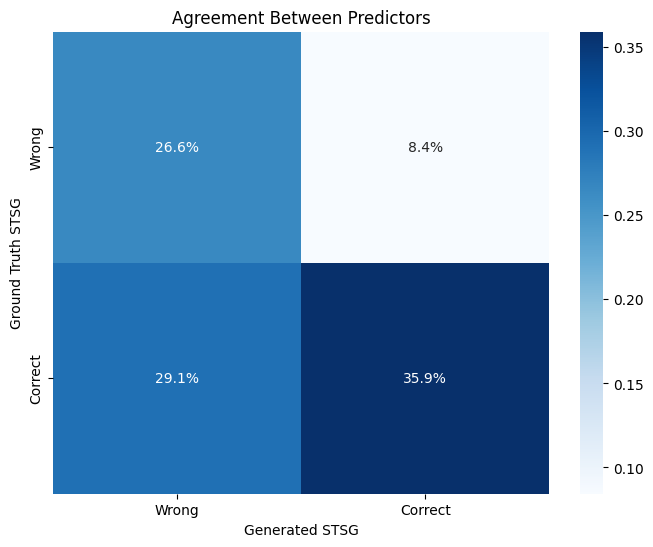

In [ ]:
gt_stsg_correct = (eval_df['text'] == eval_df['gt_stsg_pred']).astype(int).values
gen_stsg_correct = (eval_df['text'] == eval_df['gen_stsg_pred']).astype(int).values

cm = confusion_matrix(gt_stsg_correct, gen_stsg_correct)
cm_norm = cm.astype('float') / cm.sum()

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm, annot=True, fmt='.1%', cmap='Blues',
    xticklabels=['Wrong', 'Correct'], 
    yticklabels=['Wrong', 'Correct'])

plt.xlabel('Generated STSG')
plt.ylabel('Ground Truth STSG')
plt.title('Agreement Between Predictors')
plt.show()


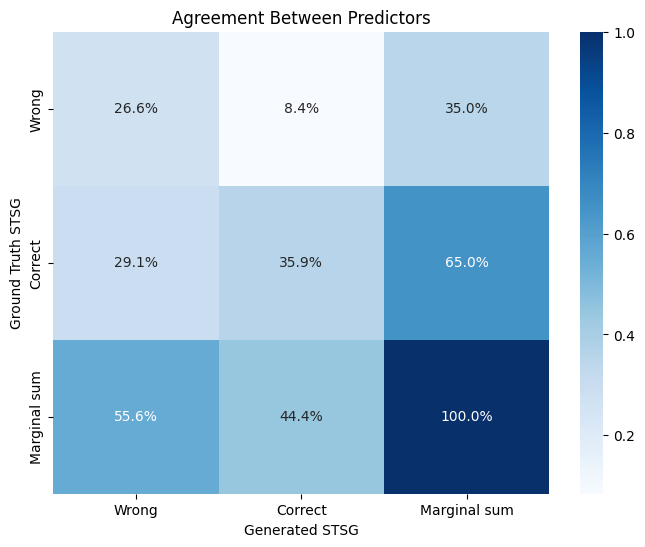

In [ ]:
gt_stsg_correct = (eval_df['text'] == eval_df['gt_stsg_pred']).astype(int).values
gen_stsg_correct = (eval_df['text'] == eval_df['gen_stsg_pred']).astype(int).values

cm = confusion_matrix(gt_stsg_correct, gen_stsg_correct)
cm_norm = cm.astype('float') / cm.sum()

extended_matrix = np.zeros((cm.shape[0]+1,cm.shape[1]+1 ))
extended_matrix[:-1, :-1] = cm_norm
extended_matrix[:-1,-1] = cm_norm.sum(axis=1) # sum the rows (i.e. sum passing by columns a[0][i] for i...)
extended_matrix[-1,:-1] = cm_norm.sum(axis=0)
extended_matrix[-1, -1] = 1.0

plt.figure(figsize=(8, 6))
sns.heatmap(
    extended_matrix, annot=True, fmt='.1%', cmap='Blues',
    xticklabels=['Wrong', 'Correct', 'Marginal sum'], 
    yticklabels=['Wrong', 'Correct', 'Marginal sum'])

plt.xlabel('Generated STSG')
plt.ylabel('Ground Truth STSG')
plt.title('Agreement Between Predictors')
plt.show()


In [49]:
wrong_wrong_mask = (gt_stsg_correct == 0) & (gen_stsg_correct == 0)
wrong_wrong_df = eval_df[wrong_wrong_mask]

wrong_but_agree = (wrong_wrong_df['gt_stsg_pred'] == wrong_wrong_df['gen_stsg_pred']).astype(int)


In [50]:
# Ground truth (0 = different wrong predictions, 1 = same wrong prediction)
y_true = np.ones_like(wrong_but_agree)  # (Assuming we want to measure agreement)

# Since we're only checking agreement, we can just count matches vs mismatches
print("Sub-Confusion Matrix for Wrong-Wrong Cases:")
print(pd.crosstab(
    wrong_but_agree,
    columns=['Prediction Agreement'],
    rownames=['Same Wrong Prediction?']
))


Sub-Confusion Matrix for Wrong-Wrong Cases:
col_0                   Prediction Agreement
Same Wrong Prediction?                      
0                                        122
1                                        196


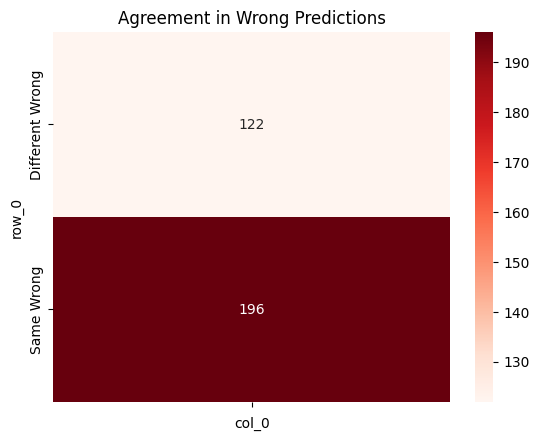

In [ ]:
sns.heatmap(
    pd.crosstab(wrong_but_agree, columns=['']),
    annot=True, fmt='d', cmap='Reds',
    xticklabels=[''],
    yticklabels=['Different Wrong', 'Same Wrong']
)
plt.title('Agreement in Wrong Predictions')
plt.show()


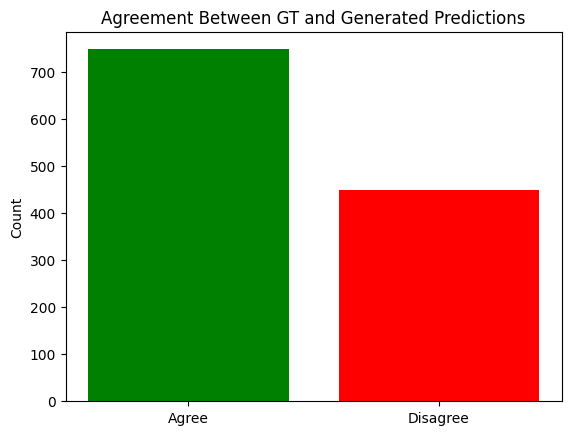

In [ ]:
agreement = np.sum(gt_stsg_correct == gen_stsg_correct)
disagreement = len(gt_stsg_correct) - agreement

plt.bar(['Agree', 'Disagree'], [agreement, disagreement], color=['green', 'red'])
plt.title('Agreement Between GT and Generated Predictions')
plt.ylabel('Count')
plt.show()


## Manual analysis

In [53]:
STAR_DATA_PATH = WORK_DIR / "data/datasets/STAR/STAR_annotations/STAR_val.json"
GT_STSG_PATH = WORK_DIR / "data/datasets/STAR_QA_and_stsg_val.json"
GEN_STSG_PATH = WORK_DIR / "outputs/gen_stsg_gemma3:12b-it-qat_20250522_14:30_99.jsonl"


In [54]:
user_prompt_format = None 
with open(WORK_DIR / "data/prompts/zero-shot-cot/MCQ_user_prompt_ZS_CoT_v2.txt") as f:
    user_prompt_format = f.read()
    
pformatter = prompt_formatters.MCQPrompt(user_prompt_format)


In [55]:
gt_dataset = STARDataset(
    qa_file_path=STAR_DATA_PATH,
    prompt_formatter=pformatter,
    stsg_file_path=GT_STSG_PATH
)



Dataset Statistics:
QA File: STAR_val.json
Number of QA samples: 7098
QA sample keys: question_id, question, video_id, start, end, answer, question_program, choices, situations, stsg

STSG File: STAR_QA_and_stsg_val.json
Number of unique video IDs with STSG: 7098



In [56]:
gen_dataset = STARDataset(
    qa_file_path=STAR_DATA_PATH,
    prompt_formatter=pformatter,
    stsg_file_path=GEN_STSG_PATH
)



Dataset Statistics:
QA File: STAR_val.json
Number of QA samples: 1694
QA sample keys: question_id, question, video_id, start, end, answer, question_program, choices, situations, stsg

STSG File: gen_stsg_gemma3:12b-it-qat_20250522_14:30_99.jsonl
Number of unique video IDs with STSG: 799



In [57]:
gt_dataset_df = pd.DataFrame([i for i in gt_dataset])
gen_dataset_df = pd.DataFrame([i for i in gen_dataset])

gt_dataset_df.set_index("question_id", inplace=True)
gen_dataset_df.set_index("question_id", inplace=True)


### GT correct - Gen Wrong

Analysis on some samples where using the ground-truth STSG leads to a correct answer, meanwhile using the generated STSG leads to a wrong one

In [58]:
correct_wrong_mask = (gt_stsg_correct == 1) & (gen_stsg_correct == 0)
correct_wrong_df = eval_df[correct_wrong_mask]

ids = correct_wrong_df.index.to_list()


In [59]:
def compact_print_qa_analysis(idx, gt_dataset_df, eval_df):
    question = gt_dataset_df.loc[idx]['question']
    gt_answer = gt_dataset_df.loc[idx]['answer'].lower()
    gt_stsg_pred = eval_df.loc[idx]['gt_stsg_pred']
    gen_stsg_pred = eval_df.loc[idx]['gen_stsg_pred']
    
    gt_status = '[CORRECT]' if gt_stsg_pred== gt_answer else '[WRONG]'
    gen_status = '[CORRECT]' if gen_stsg_pred == gt_answer else '[WRONG]'
    
    print(f"\n┌─ Sample: {str(idx)} " + "─" * (80 - len(str(idx))))
    print(f"│")
    print(f"│ Question:")
    print(f"│    {question}")
    print(f"│ Alternatives:")
    print("\n".join([f"│    {i}. {alt}" for i, alt in gt_dataset_df.loc[idx]['choices'].items()]))
    print(f"│")
    print(f"│ Ground Truth:")
    print(f"|    {gt_answer}")
    print(f"│")
    print(f"│ Model Predictions:")
    print(f"│    GT-STSG:  {gt_stsg_pred} {gt_status}")
    print(f"│    Gen-STSG: {gen_stsg_pred} {gen_status}")
    print(f"│")
    print(f"└" + "─" * 85)


### Ex. 1

In this example the error is caused by a lack of the necessary information in the generated STSG.  
Looking at the generated STSG, as the LM says, we can't see an action mentioning the man cleaning the table or the `kitchen countertop` as described in the STSG description.

In [60]:
idx = ids.pop()
idx


'Feasibility_T6_1453'

In [61]:
compact_print_qa_analysis(idx, gt_dataset_df, eval_df)



┌─ Sample: Feasibility_T6_1453 ─────────────────────────────────────────────────────────────
│
│ Question:
│    What is the person able to do after taking the towel?
│ Alternatives:
│    0. Wash the table.
│    1. Take the box.
│    2. Put down the phone/camera.
│    3. Open the bag.
│
│ Ground Truth:
|    wash the table.
│
│ Model Predictions:
│    GT-STSG:  wash the table. [CORRECT]
│    Gen-STSG: open the bag. [WRONG]
│
└─────────────────────────────────────────────────────────────────────────────────────


In [62]:
print(eval_df.loc[idx]['gt_stsg_reasoning'])


Let's analyze the Spatio-Temporal Scene Graph (STSG) to determine what the person is doing after taking the towel.

1. **Identify relevant relationships:** The STSG contains many instances of "person - holding - towel" and "person - wiping - table". These relationships indicate actions performed by the person.

2. **Look for actions immediately following towel holding:** We need to find instances where a person is holding the towel *and* immediately performing another action.

3. **Examine the graph:**  Several instances show "person - holding - towel" followed by "person - wiping - table". This suggests the person is using the towel to wipe the table.

4. **Consider the alternatives:**
   * A. Wash the table. - This aligns with the observed action of wiping the table with the towel.
   * B. Take the box. - No evidence of taking a box.
   * C. Put down the phone/camera. - No evidence of this.
   * D. Open the bag. - No evidence of this.

Therefore, the most accurate answer is A.

**Fin

In [ ]:
qaviz.Vis_SituationGraph(gt_dataset_df.loc[idx], max_show_num=1000)


0 Frame ID: 000227
Subgraph:
	 Actions:
		 take a towel/s from somewhere
	 Relationships:
		 person  ----  on_the_side_of  ----  table
		 person  ----  holding  ----  towel
		 person  ----  in_front_of  ----  towel
		 person  ----  holding  ----  bag
		 person  ----  in_front_of  ----  bag


1 Frame ID: 000237
Subgraph:
	 Actions:
		 take a towel/s from somewhere
	 Relationships:
		 person  ----  in_front_of  ----  table
		 person  ----  in_front_of  ----  towel
		 person  ----  holding  ----  bag
		 person  ----  in_front_of  ----  bag


2 Frame ID: 000251
Subgraph:
	 Actions:
		 take a towel/s from somewhere
	 Relationships:
		 person  ----  in_front_of  ----  towel
		 person  ----  in_front_of  ----  bag


3 Frame ID: 000257
Subgraph:
	 Actions:
		 take a towel/s from somewhere
	 Relationships:
		 person  ----  in_front_of  ----  table
		 person  ----  in_front_of  ----  bag


4 Frame ID: 000268
Subgraph:
	 Actions:
		 take a towel/s from somewhere
	 Relationships:
		 person  ----  

In [64]:
print(eval_df.loc[idx]['gen_stsg_reasoning'])


Okay, let's analyze the scene graph and answer the question step-by-step.

**1. Question Interpretation:**

The question asks what the person (young man) is able to do *after* holding a towel. The scene graph describes a sequence of actions and objects in a kitchen environment. We need to find an action that logically follows the act of holding a towel.

**2. STSG Analysis:**

Let’s examine the final frame (Frame 4) of the scene graph. The young man is holding a “white_bag” and “interacting_with a digital_scale” on the “kitchen_countertop”. The scene graph shows the young man holding a white bag and interacting with a digital scale.  The previous frames show the young man washing plates and bowls, using a dishcloth, and generally cleaning.  The towel is not explicitly mentioned in the scene graph, but the context suggests he’s likely cleaning.

**3. Alternative Evaluation:**

*   **A. Wash the table:** The scene graph doesn’t show the table being dirty or the young man washing it.
*   

In [65]:
print(gen_dataset_df.loc[idx]['stsg'])



Frame 0:


man ---- standing_on ---- countertop
man ---- holding ---- spatula
stove ---- on ---- countertop
pots ---- surrounding ---- stove
sink ---- next_to ---- stove
sink ---- on ---- countertop
faucet ---- attached_to ---- sink
wall_tiles ---- behind ---- stove
wall_tiles ---- behind ---- sink
light_fixture ---- above ---- stove
window ---- above ---- sink
building_exterior ---- visible_through ---- window
electrical_outlet ---- on ---- wall
man ---- near ---- pots
man ---- looking_at ---- stove
countertop ---- below ---- cabinets

Frame 1:


young_man ---- standing_on ---- kitchen_countertop
young_man ---- holding ---- spatula
young_man ---- preparing ---- vegetables
kitchen_countertop ---- has_sink ---- sink
sink ---- has_faucet ---- faucet
kitchen_countertop ---- has_stove ---- stove
stove ---- has_burner ---- burner
stove ---- has_pot ---- pot
pot ---- on_top_of ---- burner
vegetables ---- on_top_of ---- cutting_board
cutting_board ---- on_top_of ---- kitchen_countertop
kitch

In [66]:
qaviz.Vis_Video(
    {"question_id": idx, **gt_dataset_df.loc[idx].to_dict()},
    RAW_VIDEO_DIR,
    SAVE_VIDEO_DIR)


	Video Seg:  7.3s - 12.9s


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

### Ex. 2

As the example before, even in this case the generated STSG is not descriptive enough. The clothes, which are essential in answering the question, aren't mentioned a single time in the STSG.

In [67]:
idx = ids.pop()
idx


'Feasibility_T6_978'

In [68]:
compact_print_qa_analysis(idx, gt_dataset_df, eval_df)



┌─ Sample: Feasibility_T6_978 ──────────────────────────────────────────────────────────────
│
│ Question:
│    What is the person able to do after tidying up the blanket?
│ Alternatives:
│    0. Open the laptop.
│    1. Sit on the bed.
│    2. Close the closet/cabinet.
│    3. Put down the clothes.
│
│ Ground Truth:
|    put down the clothes.
│
│ Model Predictions:
│    GT-STSG:  put down the clothes. [CORRECT]
│    Gen-STSG: open the laptop. [WRONG]
│
└─────────────────────────────────────────────────────────────────────────────────────


In [69]:
print(eval_df.loc[idx]['gt_stsg_reasoning'])


Okay, let's analyze the Spatio-Temporal Scene Graph to answer the question: "What is the person able to do after tidying up the blanket?".

**Step 1: Identify Relevant Actions & Relationships**

The question asks about what the person *does* after tidying up the blanket. We need to find actions related to tidying up and the objects involved. The key phrases in the STSG related to this are:

*   `person - holding - blanket`
*   `person - sitting_on - sofa/couch`
*   The subsequent actions involving clothes, sandwich, and dishes.

**Step 2: Trace the Scene Graph for Relevant Actions**

The STSG describes a scene where a person is primarily interacting with a sofa/couch, clothes, a blanket, and eventually a sandwich and dishes. The core activity is the person sitting on the sofa/couch while handling these items. The graph shows the person repeatedly holding, in front of, sitting on, behind, beneath, and leaning on the sofa/couch and the blanket.

**Step 3: Determine the Likely Action**

G

In [ ]:
qaviz.Vis_SituationGraph(gt_dataset_df.loc[idx], max_show_num=1000)


0 Frame ID: 000106
Subgraph:
	 Actions:
		 tidy up a blanket/s
	 Relationships:
		 person  ----  holding  ----  clothes
		 person  ----  in_front_of  ----  clothes
		 person  ----  sitting_on  ----  sofa/couch
		 person  ----  behind  ----  sofa/couch


1 Frame ID: 000120
Subgraph:
	 Actions:
		 tidy up a blanket/s
	 Relationships:
		 person  ----  holding  ----  clothes
		 person  ----  in_front_of  ----  clothes
		 person  ----  sitting_on  ----  sofa/couch
		 person  ----  beneath  ----  sofa/couch
		 person  ----  behind  ----  sofa/couch
		 person  ----  holding  ----  blanket
		 person  ----  in_front_of  ----  blanket


2 Frame ID: 000137
Subgraph:
	 Actions:
		 tidy up a blanket/s
	 Relationships:
		 person  ----  holding  ----  clothes
		 person  ----  in_front_of  ----  clothes
		 person  ----  sitting_on  ----  sofa/couch
		 person  ----  behind  ----  sofa/couch
		 person  ----  beneath  ----  sofa/couch


3 Frame ID: 000167
Subgraph:
	 Actions:
		 tidy up a blanket/s
	 Rel

In [71]:
print(eval_df.loc[idx]['gen_stsg_reasoning'])


Okay, let's analyze the question and the scene graph to determine the most likely answer.

**1. Question Interpretation:**

The question asks what the person (presumably the woman) is able to do *after* tidying up the blanket. Tidying up the blanket implies a state of order and cleanliness. We need to find an action the woman can perform in this state.

**2. STSG Analysis:**

Let’s examine the scene graphs to understand the current state and potential actions.

*   **Frame 0-4:** The scene depicts a living room with a woman, sofa, blanket, and various objects. The blanket is draped over the sofa. The question asks about what she can do *after* tidying it up.
*   **Frame 0:** The blanket is draped over the sofa.
*   **Frame 1-4:** The scene graph shows the blanket being tidied up (covered by a sheet in Frame 4).
*   **Frame 4:** The woman is sitting on the sofa, holding a tablet.

**3. Alternative Evaluation:**

*   **A. Open the laptop.** – The scene graph doesn't show a laptop or any 

In [72]:
print(gen_dataset_df.loc[idx]['stsg'])



Frame 0:


woman ---- holding ---- white_plate
white_plate ---- contains ---- food_on_plate
woman ---- sitting_on ---- sofa
sofa ---- has_cushions ---- sofa_cushions
sofa_cushions ---- patterned ---- patterned_design
sofa ---- in_front_of ---- wall
wall ---- behind ---- sofa
wall ---- has_curtains ---- curtains
wall ---- has_picture_frame ---- picture_frame
picture_frame ---- on_top_of ---- sofa
light_fixture ---- above ---- woman
light_fixture ---- attached_to ---- ceiling
cabinet ---- to_right_of ---- woman
cabinet ---- displays ---- decorative_items
floor ---- below ---- woman
floor ---- below ---- sofa

Frame 1:

woman ---- sitting_on ---- sofa
sofa ---- has_cushion ---- cushion
cushion ---- patterned_with ---- floral_pattern
woman ---- holding ---- plate
woman ---- holding ---- fork
plate ---- in_front_of ---- woman
fork ---- in_front_of ---- woman
sofa ---- positioned_in_front_of ---- cabinet
cabinet ---- located_behind ---- sofa
cabinet ---- has_shelf ---- shelf
shelf ---- disp

Looking at the mentioned generated STSG we can't see an action mentioning the man cleaning the table or the `kitchen countertop` as described in the STSG description.

In [73]:
qaviz.Vis_Video(
    {"question_id": idx, **gt_dataset_df.loc[idx].to_dict()},
    RAW_VIDEO_DIR,
    SAVE_VIDEO_DIR)


	Video Seg:  3.0s - 8.1s


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

### Ex. 3

The reason why the generated STSG leads to a misprediction is the same as the above examples, the essential object in determining the answer is not mentioned in the Graph, i.e. the box or shoe-box.

**Note**: An Error in the ground truth. The STSG reports a relationship woman - wearing - show, which is not visible in the video and considering this is a Feasibility question (what a person is able to do), therefore this tuple should not be present in the Graph.

In [74]:
idx = ids.pop()
idx


'Feasibility_T6_709'

In [75]:
compact_print_qa_analysis(idx, gt_dataset_df, eval_df)



┌─ Sample: Feasibility_T6_709 ──────────────────────────────────────────────────────────────
│
│ Question:
│    What is the person able to do after putting down the pillow?
│ Alternatives:
│    0. Hold the food.
│    1. Sit at the table.
│    2. Throw the box.
│    3. Hold the picture.
│
│ Ground Truth:
|    hold the food.
│
│ Model Predictions:
│    GT-STSG:  hold the food. [CORRECT]
│    Gen-STSG: hold the picture. [WRONG]
│
└─────────────────────────────────────────────────────────────────────────────────────


In [76]:
print(eval_df.loc[idx]['gt_stsg_reasoning'])


Let's analyze the scene graph to determine what the person is doing after putting down the pillow.

1. **Identify relevant relationships:** We need to find relationships involving "person" and "pillow" that indicate an action *after* the pillow is down. The graph describes various interactions with the pillow: 'touching', 'holding', 'in_front_of'.

2. **Search for actions:**  Looking through the scene graph, we find several instances where the person is interacting with the pillow. Specifically, we see:
   - `['person - holding - pillow', 'person - on_the_side_of - pillow']`
   - `['person - holding - food', 'person - in_front_of - food']`
   - `['person - holding - food', 'person - in_front_of - food']`

3. **Determine the action:** The most relevant action is "holding food" which is directly linked to the "person" and "food" through the relationship "in_front_of".

4. **Evaluate Alternatives:**
   - A. Hold the food. - This aligns with our analysis.
   - B. Sit at the table. - There'

In [77]:
qaviz.Vis_SituationGraph(gt_dataset_df.loc[idx], max_show_num=1000)


0 Frame ID: 000093
Subgraph:
	 Actions:
		 put a pillow somewhere
	 Relationships:
		 person  ----  beneath  ----  sofa/couch
		 person  ----  on_the_side_of  ----  sofa/couch
		 person  ----  in_front_of  ----  pillow


1 Frame ID: 000105
Subgraph:
	 Actions:
		 put a pillow somewhere
	 Relationships:
		 person  ----  beneath  ----  sofa/couch
		 person  ----  on_the_side_of  ----  sofa/couch
		 person  ----  behind  ----  pillow


2 Frame ID: 000106
Subgraph:
	 Actions:
		 put a pillow somewhere
	 Relationships:
		 person  ----  on_the_side_of  ----  sofa/couch
		 person  ----  beneath  ----  sofa/couch
		 person  ----  in_front_of  ----  pillow


3 Frame ID: 000123
Subgraph:
	 Actions:
		 put a pillow somewhere
	 Relationships:
		 person  ----  behind  ----  sofa/couch
		 person  ----  beneath  ----  sofa/couch
		 person  ----  behind  ----  pillow


4 Frame ID: 000136
Subgraph:
	 Actions:
		 put a pillow somewhere
	 Relationships:
		 person  ----  behind  ----  sofa/couch
		 person

In [78]:
print(eval_df.loc[idx]['gen_stsg_reasoning'])


Okay, let's analyze the Spatio-Temporal Scene Graph and answer the question.

1. **Question Interpretation:** The question asks what the person (the woman) is able to do *after* putting down the pillow. The STSG provides a sequence of frames, and we need to find an action that occurs *after* the pillow is no longer present in the scene.

2. **STSG Analysis:**  I need to examine the frames to see when the pillow is last mentioned and then look for actions that follow. The STSG shows the woman holding a pillow in Frame 3 and Frame 4.  Let’s look at Frame 4. In Frame 4, the woman is sitting on the sofa, holding a dog, and there are items on the coffee table (mug, book, remote control, plant).  There is no mention of the pillow in Frame 4.  The woman is holding a dog.

3. **Alternative Evaluation:**
   * **A. Hold the food:** There is no mention of food in the STSG.
   * **B. Sit at the table:** There is no table described in the STSG.
   * **C. Throw the box:** There is no box mentioned i

In [79]:
print(gen_dataset_df.loc[idx]['stsg'])



Frame 0:

woman ---- standing_in_front_of ---- chair
chair ---- positioned_near ---- window
window ---- set_into ---- wall
curtains ---- hanging_in_front_of ---- window
woman ---- positioned_to_the_left_of ---- window
chair ---- positioned_between ---- woman
chair ---- resting_on ---- floor
woman ---- illuminated_by ---- sunlight
sunlight ---- coming_from ---- right
curtains ---- covering ---- window
wall ---- supporting ---- window
floor ---- beneath ---- woman
floor ---- beneath ---- chair
woman ---- casting_shadow_on ---- floor

Frame 1:

woman ---- standing_in_front_of ---- sofa
woman ---- looking_at ---- outside
sofa ---- positioned_in_front_of ---- coffee_table
coffee_table ---- positioned_in_front_of ---- sofa
lamp ---- positioned_to_right_of ---- sofa
lamp ---- positioned_behind ---- coffee_table
curtains ---- covering ---- window
curtains ---- hanging_from ---- rod
rod ---- mounted_on ---- wall
sofa ---- resting_on ---- floor
lamp ---- resting_on ---- floor
woman ---- standin

In [ ]:
qaviz.Vis_Video(
    {"question_id": idx, **gt_dataset_df.loc[idx].to_dict()},
    RAW_VIDEO_DIR,
    SAVE_VIDEO_DIR)


	Video Seg:  2.9s - 9.4s


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

### Ex. 4

Same... No relevant information in the scene graph pertaining to the question.

In [81]:
idx = ids.pop()
idx


'Feasibility_T6_483'

In [82]:
compact_print_qa_analysis(idx, gt_dataset_df, eval_df)



┌─ Sample: Feasibility_T6_483 ──────────────────────────────────────────────────────────────
│
│ Question:
│    What is the person able to do after throwing the clothes?
│ Alternatives:
│    0. Hold the pillow.
│    1. Take the pillow.
│    2. Open the book.
│    3. Open the bag.
│
│ Ground Truth:
|    open the bag.
│
│ Model Predictions:
│    GT-STSG:  open the bag. [CORRECT]
│    Gen-STSG: hold the pillow. [WRONG]
│
└─────────────────────────────────────────────────────────────────────────────────────


In [83]:
print(eval_df.loc[idx]['gt_stsg_reasoning'])


Let's analyze the STSG to determine what the person is doing after throwing the clothes. The key here is to identify actions related to "throwing" and what the person is doing *immediately* afterward.

1. **Identify relevant relationships:** The STSG contains many relationships involving "holding" and "throwing" (implicitly). We need to find instances where a person is *throwing* something.

2. **Search for "throwing" actions:**  Looking through the STSG, we find several instances of "person - holding - clothes" and "person - throwing - clothes" (although not explicitly stated, the relationships imply throwing).  Crucially, there are multiple instances of "person - holding - clothes" followed by actions like "person - in_front_of - clothes", "person - on_the_side_of - clothes", "person - beneath - bed", etc. This indicates the person was initially holding clothes.

3. **Consider the immediate aftermath:** The question asks what the person *does after* throwing the clothes. The STSG doe

In [ ]:
qaviz.Vis_SituationGraph(gt_dataset_df.loc[idx], max_show_num=1000)


0 Frame ID: 000245
Subgraph:
	 Actions:
		 throw clothes somewhere
	 Relationships:
		 person  ----  holding  ----  clothes
		 person  ----  in_front_of  ----  clothes


1 Frame ID: 000252
Subgraph:
	 Actions:
		 throw clothes somewhere
	 Relationships:
		 person  ----  holding  ----  clothes
		 person  ----  in_front_of  ----  clothes


2 Frame ID: 000334
Subgraph:
	 Actions:
		 throw clothes somewhere
	 Relationships:
		 person  ----  holding  ----  clothes
		 person  ----  on_the_side_of  ----  clothes


3 Frame ID: 000374
Subgraph:
	 Actions:
		 take some clothes from somewhere ,throw clothes somewhere
	 Relationships:
		 person  ----  in_front_of  ----  food


4 Frame ID: 000394
Subgraph:
	 Actions:
		 take some clothes from somewhere ,take a bag from somewhere ,throw clothes somewhere
	 Relationships:
		 person  ----  in_front_of  ----  bag


5 Frame ID: 000403
Subgraph:
	 Actions:
		 take some clothes from somewhere ,take a bag from somewhere ,throw clothes somewhere
	 Relations

In [85]:
print(eval_df.loc[idx]['gen_stsg_reasoning'])


Okay, let's analyze the scene graph and answer the question.

**1. Question Interpretation:**

The question asks what the person (presumably the woman) is able to do *after* throwing the clothes. The scene graph doesn't explicitly state that clothes are thrown. However, we can infer that the question is asking about an action the woman might perform *after* a change in the scene, possibly related to the removal of clothing.

**2. STSG Analysis:**

The scene graph describes a series of frames depicting a woman in a bedroom setting. We see her interacting with the bed, pillows, and a camera. There’s no mention of throwing clothes. The woman is holding a water bottle in the last frame. The scene focuses on her presence and actions related to the bed and camera.

**3. Alternative Evaluation:**

*   **A. Hold the pillow.** The STSG shows the woman holding a water bottle in the last frame. It also shows her arranging pillows on the bed. Therefore, she is capable of holding a pillow.
*   **B.

In [86]:
print(gen_dataset_df.loc[idx]['stsg'])



Frame 0:

woman ---- standing_in_front_of ---- bed
bed ---- positioned_against ---- wall
camera_tripod ---- located_in_front_of ---- woman
camera_tripod ---- located_in_front_of ---- bed
camera ---- attached_to ---- camera_tripod
microphone ---- attached_to ---- camera_tripod
cable ---- connected_to ---- microphone
wall ---- behind ---- bed
wall ---- behind ---- woman
light_fixture ---- mounted_on ---- wall
curtain ---- hanging_on ---- wall
woman ---- facing ---- camera
camera ---- pointing_at ---- woman
bed ---- has ---- pillows
pillows ---- on_top_of ---- bed

Frame 1:

woman ---- looking_at ---- camera
camera ---- attached_to ---- tripod
tripod ---- positioned_in_front_of ---- bed
bed ---- against ---- wall
wall ---- behind ---- bed
window ---- on ---- wall
curtains ---- visible_through ---- window
light_fixture ---- above ---- bed
woman ---- positioned_in_front_of ---- bed
wooden_chair ---- to_left_of ---- bed
microphone ---- attached_to ---- camera
woman ---- wearing ---- dark_to

In [87]:
qaviz.Vis_Video(
    {"question_id": idx, **gt_dataset_df.loc[idx].to_dict()},
    RAW_VIDEO_DIR,
    SAVE_VIDEO_DIR)


	Video Seg:  7.7s - 14.5s


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

### Ex. 5

Same as above.

In [88]:
idx = ids.pop()
idx


'Feasibility_T6_405'

In [ ]:
compact_print_qa_analysis(idx, gt_dataset_df, eval_df)



┌─ Sample: Feasibility_T6_405 ──────────────────────────────────────────────────────────────
│
│ Question:
│    What is the person able to do after tidying up the closet/cabinet?
│ Alternatives:
│    0. Eat the medicine.
│    1. Throw the towel.
│    2. Put down the bag.
│    3. Throw the clothes.
│
│ Ground Truth:
|    throw the clothes.
│
│ Model Predictions:
│    GT-STSG:  throw the clothes. [CORRECT]
│    Gen-STSG: put down the bag. [WRONG]
│
└─────────────────────────────────────────────────────────────────────────────────────


In [90]:
print(eval_df.loc[idx]['gt_stsg_reasoning'])


Okay, let's analyze the STSG to determine what the person is doing after tidying up the closet/cabinet.

1. **Observe the Scene Graph:** The STSG describes a complex scene with multiple people interacting with various objects – a closet/cabinet, towels, clothes, blankets, a door, and a towel. There are many instances of a person 'holding', 'touching', 'in front of', 'on the side of', and 'behind' these objects.

2. **Identify Relevant Actions:** We need to find actions related to tidying up or putting things away.  Several instances show a person 'holding' and 'putting down' objects. Specifically, there are many instances of a person holding the closet/cabinet, towels, clothes, and blankets.

3. **Look for Actions Related to Disposal/Putting Away:** The key is to find actions that indicate the person is finishing the tidying process. The STSG shows a person repeatedly 'holding' and 'putting down' items.

4. **Evaluate Alternatives:**
   * **A. Eat the medicine:** This is not supported 

In [ ]:
qaviz.Vis_SituationGraph(gt_dataset_df.loc[idx], max_show_num=1000)


0 Frame ID: 000506
Subgraph:
	 Actions:
		 tidy up a closet/cabinet
	 Relationships:
		 person  ----  in_front_of  ----  closet/cabinet
		 person  ----  touching  ----  door
		 person  ----  in_front_of  ----  door


1 Frame ID: 000525
Subgraph:
	 Actions:
		 tidy up a closet/cabinet ,hold some clothes ,take some clothes from somewhere
	 Relationships:
		 person  ----  holding  ----  closet/cabinet
		 person  ----  in_front_of  ----  closet/cabinet
		 person  ----  in_front_of  ----  door


2 Frame ID: 000533
Subgraph:
	 Actions:
		 tidy up a closet/cabinet ,hold some clothes ,take some clothes from somewhere
	 Relationships:
		 person  ----  holding  ----  closet/cabinet
		 person  ----  in_front_of  ----  closet/cabinet
		 person  ----  in_front_of  ----  door


3 Frame ID: 000541
Subgraph:
	 Actions:
		 tidy up a closet/cabinet ,hold some clothes ,take some clothes from somewhere
	 Relationships:
		 person  ----  holding  ----  closet/cabinet
		 person  ----  in_front_of  ----  clos

In [92]:
print(eval_df.loc[idx]['gen_stsg_reasoning'])


Okay, let's analyze the scene graph and answer the question step-by-step.

**1. Question Interpretation:**

The question asks what the person (the woman) is able to do *after* tidying up the closet/cabinet.  Tidying up implies organizing and potentially removing items from the closet. We need to identify an action the woman can perform *after* this organizational activity.

**2. STSG Analysis:**

Let's examine the scene graph to understand the woman's actions and the environment:

*   **Frames 1-4:** The scene depicts a room with a woman, furniture (chairs, rugs, walls, doors, closets), and various objects (clothes, shelves, curtains, a fan, a cityscape).
*   **Frame 1:** The woman is holding a door handle, suggesting she’s interacting with a door.
*   **Frame 2:** The woman is holding near a fan.
*   **Frame 3:** The woman is holding a white t-shirt and is standing in front of a door.
*   **Frame 4:** The woman is carrying a backpack.

The key observation is that in Frame 4, the woman

In [93]:
print(gen_dataset_df.loc[idx]['stsg'])



Frame 0:


woman ---- wearing ---- gray_sweatpants
woman ---- wearing ---- white_t_shirt
woman ---- wearing ---- sandals
woman ---- standing_in_front_of ---- chair
chair ---- against ---- wall
wall ---- has_on ---- picture_frame_1
wall ---- has_on ---- picture_frame_2
wall ---- has_on ---- picture_frame_3
rug ---- on ---- floor
floor ---- covered_with ---- rug
window ---- behind ---- chair
window ---- covered_by ---- curtains
curtains ---- hanging_from ---- curtain_rod (implied)
light_source ---- illuminating ---- scene
shadows ---- cast_by ---- woman
shadows ---- cast_by ---- chair
rug ---- under ---- woman
rug ---- under ---- chair


Frame 1:

woman ---- wearing ---- black_t_shirt
woman ---- wearing ---- gray_leggings
woman ---- standing_on ---- floor
floor ---- covered_by ---- patterned_rug
woman ---- holding ---- door_handle
door_handle ---- attached_to ---- door
door ---- attached_to ---- wall
wall ---- behind ---- woman
door ---- leading_to ---- closet_interior
closet_interior -

In [94]:
qaviz.Vis_Video(
    {"question_id": idx, **gt_dataset_df.loc[idx].to_dict()},
    RAW_VIDEO_DIR,
    SAVE_VIDEO_DIR)


	Video Seg:  16.8s - 24.3s


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

## Interaction Question type

In [104]:
ids = [i for i in ids if i.startswith('I')]
len(ids)
np.random.shuffle(ids)


### Ex. I1

In [121]:
idx = ids.pop()
idx


'Interaction_T2_1847'

In [122]:
compact_print_qa_analysis(idx, gt_dataset_df, eval_df)



┌─ Sample: Interaction_T2_1847 ─────────────────────────────────────────────────────────────
│
│ Question:
│    What did the person do with the paper/notebook?
│ Alternatives:
│    0. Put down.
│    1. Sat on.
│    2. Washed.
│    3. Took.
│
│ Ground Truth:
|    took.
│
│ Model Predictions:
│    GT-STSG:  took. [CORRECT]
│    Gen-STSG: took. [CORRECT]
│
└─────────────────────────────────────────────────────────────────────────────────────


In [123]:
print(eval_df.loc[idx]['gt_stsg_reasoning'])


Okay, let's analyze the scene graph and answer the question.

**1. Understanding the Scene Graph:**

The scene graph describes a scenario with multiple people and their interactions with objects. The key relationships are:

*   `person - holding - paper/notebook`: This indicates a person is holding a paper/notebook.
*   `person - in_front_of - paper/notebook`: This indicates a person is positioned in front of the paper/notebook.

**2. Reasoning:**

The scene graph explicitly states that a person is *holding* the paper/notebook and that another person is *in front of* it. This suggests an active interaction. The alternatives are:

*   A. Put down - This doesn't directly relate to the graph's description.
*   B. Sat on - This is incorrect, as the graph doesn't show the person sitting on the paper/notebook.
*   C. Washed - This is completely unrelated to the scene.
*   D. Took - This is the most accurate description of the action implied by "holding" the paper/notebook.

**3. Final Answer

In [124]:
gt_dataset_df.loc[idx]['situations']


{'000210': {'rel_pairs': [['o000', 'o011']],
  'rel_labels': ['r003'],
  'actions': ['a090'],
  'bbox': [[27.58, 134.33, 142.58, 252.83], [214.04, 109.13, 367.87, 296.37]],
  'bbox_labels': ['o011', 'o000']},
 '000211': {'rel_pairs': [['o000', 'o011']],
  'rel_labels': ['r003'],
  'actions': ['a090'],
  'bbox': [[29.22, 136.56, 142.0, 252.67]],
  'bbox_labels': ['o011']},
 '000275': {'rel_pairs': [['o000', 'o007'], ['o000', 'o007']],
  'rel_labels': ['r009', 'r002'],
  'actions': ['a090'],
  'bbox': [[283.01, 169.63, 326.94, 220.34], [270.91, 112.24, 397.13, 309.01]],
  'bbox_labels': ['o007', 'o000']},
 '000271': {'rel_pairs': [['o000', 'o007'], ['o000', 'o007']],
  'rel_labels': ['r009', 'r002'],
  'actions': ['a090'],
  'bbox': [[293.13, 171.57, 338.95, 211.57], [275.67, 80.24, 407.93, 294.79]],
  'bbox_labels': ['o007', 'o000']},
 '000270': {'rel_pairs': [['o000', 'o007'], ['o000', 'o007']],
  'rel_labels': ['r009', 'r002'],
  'actions': ['a090'],
  'bbox': [[292.29, 176.51, 337.03

In [125]:
qaviz.Vis_SituationGraph(gt_dataset_df.loc[idx], max_show_num=1000)


0 Frame ID: 000210
Subgraph:
	 Actions:
		 take paper/notebook from somewhere
	 Relationships:
		 person  ----  on_the_side_of  ----  shelf


1 Frame ID: 000211
Subgraph:
	 Actions:
		 take paper/notebook from somewhere
	 Relationships:
		 person  ----  on_the_side_of  ----  shelf


2 Frame ID: 000270
Subgraph:
	 Actions:
		 take paper/notebook from somewhere
	 Relationships:
		 person  ----  holding  ----  paper/notebook
		 person  ----  in_front_of  ----  paper/notebook


3 Frame ID: 000271
Subgraph:
	 Actions:
		 take paper/notebook from somewhere
	 Relationships:
		 person  ----  holding  ----  paper/notebook
		 person  ----  in_front_of  ----  paper/notebook


4 Frame ID: 000275
Subgraph:
	 Actions:
		 take paper/notebook from somewhere
	 Relationships:
		 person  ----  holding  ----  paper/notebook
		 person  ----  in_front_of  ----  paper/notebook


5 Frame ID: 000277
Subgraph:
	 Actions:
		 take paper/notebook from somewhere
	 Relationships:
		 person  ----  holding  ----  pape

In [126]:
print(eval_df.loc[idx]['gen_stsg_reasoning'])


Okay, let's analyze the scene graph and answer the question about the paper/notebook.

**1. Question Interpretation:**

The question asks what the person (the woman) did with a paper/notebook. We need to find evidence in the scene graph that describes an action involving this object.

**2. STSG Analysis:**

Let's examine the scene graph for clues about the woman's actions and the presence of a paper/notebook.

*   **Frame 0:** The woman is carrying a backpack. This doesn’t directly relate to a paper/notebook.
*   **Frame 1:** The woman is holding sheet music. Sheet music is a type of paper.
*   **Frame 2:** The woman is wearing a dress/top. This doesn’t relate to a paper/notebook.
*   **Frame 3:** The woman is wearing a red t-shirt and dark pants. This doesn’t relate to a paper/notebook.

The most relevant information is in Frame 1, where the woman is holding sheet music.

**3. Alternative Evaluation:**

*   **A. Put down:** The scene graph doesn’t show the woman putting anything down.

In [127]:
print(gen_dataset_df.loc[idx]['stsg'])



Frame 0:

woman ---- wearing ---- white_t_shirt
woman ---- wearing ---- dark_pants
woman ---- carrying ---- backpack
woman ---- standing_in_front_of ---- window
window ---- covered_by ---- curtains
curtains ---- hanging_from ---- window_rod
window ---- behind ---- woman
light_fixture ---- hanging_from ---- ceiling
light_fixture ---- illuminating ---- woman
light_source ---- positioned_to_right_of ---- woman
light_source ---- casting_shadows_on ---- wall
light_source ---- casting_shadows_on ---- floor
woman ---- standing_on ---- floor
ceiling ---- above ---- woman
wall ---- behind ---- window

Frame 1:

woman ---- standing_in_front_of ---- piano
piano ---- positioned_near ---- window
window ---- on_wall ---- behind
curtains ---- hanging_over ---- window
floor ---- beneath ---- piano
floor ---- beneath ---- woman
woman ---- holding ---- sheet_music
sheet_music ---- resting_on ---- piano_music_stand
piano_music_stand ---- attached_to ---- piano
light_source ---- illuminating ---- woman
l

In [129]:
gt_dataset_df.loc[idx]['video_id']


'1TIAK'

In [128]:
qaviz.Vis_Video(
    {"question_id": idx, **gt_dataset_df.loc[idx].to_dict()},
    RAW_VIDEO_DIR,
    SAVE_VIDEO_DIR)


	Video Seg:  8.3s - 12.5s


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

## Correct-Correct samples

In [103]:
correct_correct_mask = (gt_stsg_correct == 1) & (gen_stsg_correct == 1)
correct_correct_df = eval_df[correct_correct_mask]

ids = correct_correct_df.index.to_list()
